# Foody - Food classifier
version 0.4 by BennyFace

model: foody_v04_convnext_small_in22k.pkl
dataset: food101 https://huggingface.co/datasets/food101

In [1]:
from fastai.vision.all import *
import gradio as gr
import os
import timm

In [2]:
home_path = os.getcwd()
home_path

'/home/bennyface'

In [3]:
home = Path(home_path)

In [4]:
# trn_path = home/'train_images'
trn_path = '/mnt/d/datasets/food-101_MINI'  
trn_path

'/mnt/d/datasets/food-101_MINI'

In [5]:
files = get_image_files(trn_path)

In [6]:
files

(#14994) [Path('/mnt/d/datasets/food-101_MINI/apple_pie/1005649.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1011328.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/101251.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1014775.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1026328.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1028787.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1034399.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/103801.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1038694.jpg'),Path('/mnt/d/datasets/food-101_MINI/apple_pie/1043283.jpg')...]

In [7]:
# check for corrupt images.
corrupt = verify_images(files)
corrupt

(#0) []

(308, 512)


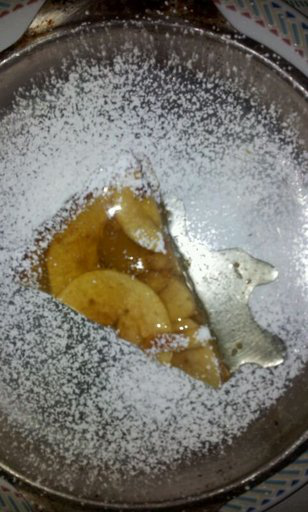

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(512)

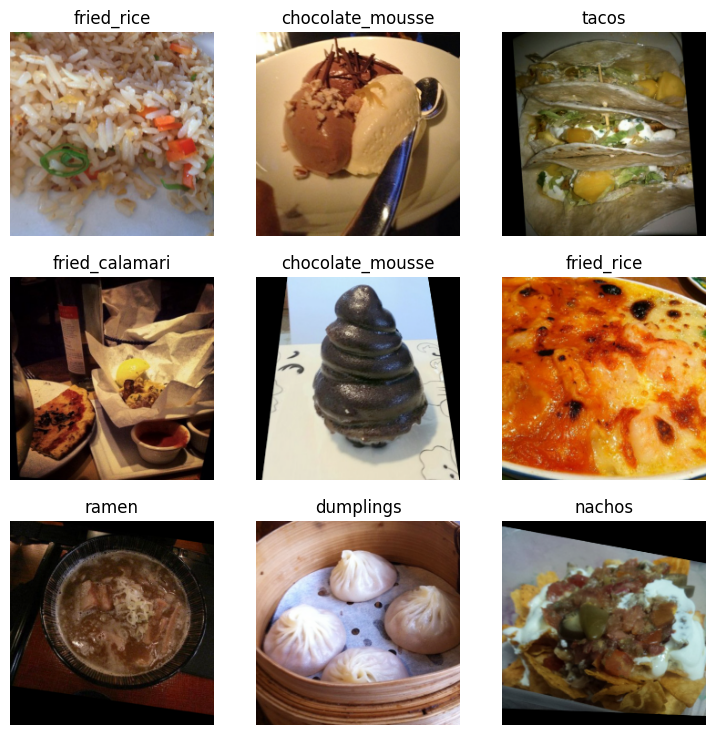

In [9]:
accum = 2 #reduce video ram - 2 works for my rtx 3060 12GB

dls = ImageDataLoaders.from_folder(
    trn_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),  # method='squish', method='randomresizecrop'  #, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=64//accum
)

dls.show_batch(max_n=9)


In [10]:
cbs = GradientAccumulation(64) if accum else []
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, cbs=cbs).to_fp16()

SuggestedLRs(valley=0.0006918309954926372, slide=3.0199516913853586e-05)

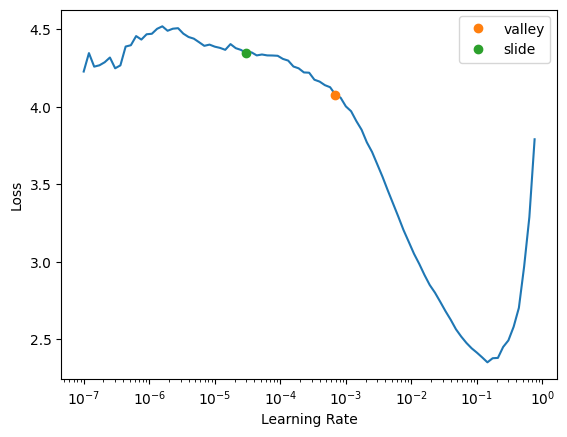

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))

In [12]:
#train the model
learn.fine_tune(10, 0.003)

epoch,train_loss,valid_loss,error_rate,time
0,0.367258,0.227660,0.064710,01:55


epoch,train_loss,valid_loss,error_rate,time
0,0.235058,0.163924,0.053369,02:26
1,0.206123,0.157753,0.048032,02:22
2,0.211025,0.175656,0.055370,02:24
3,0.143954,0.172358,0.048699,02:17
4,0.129118,0.158874,0.047365,02:22
5,0.077155,0.158085,0.049700,02:22
6,0.056498,0.167562,0.043362,02:22
7,0.053550,0.163218,0.043362,02:23
8,0.036658,0.166832,0.044029,02:23
9,0.022725,0.166679,0.044363,02:22


In [13]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0444)

In [14]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0404)

In [15]:
# get the index with the greater probability
preds = probs.argmax(dim=1)

In [16]:
dls.vocab[preds]

(#2998) ['hamburger','nachos','fried_rice','onion_rings','ice_cream','onion_rings','ramen','apple_pie','pad_thai','nachos'...]

In [17]:
learn.export('/home/bennyface/foody_v4_convnext_small_in22k.pkl')

In [18]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

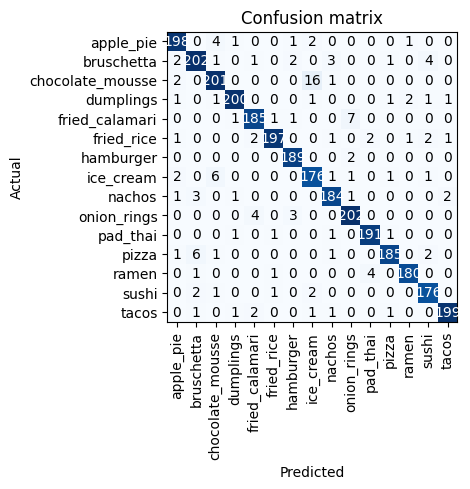

In [19]:
learning_interpreter.plot_confusion_matrix()

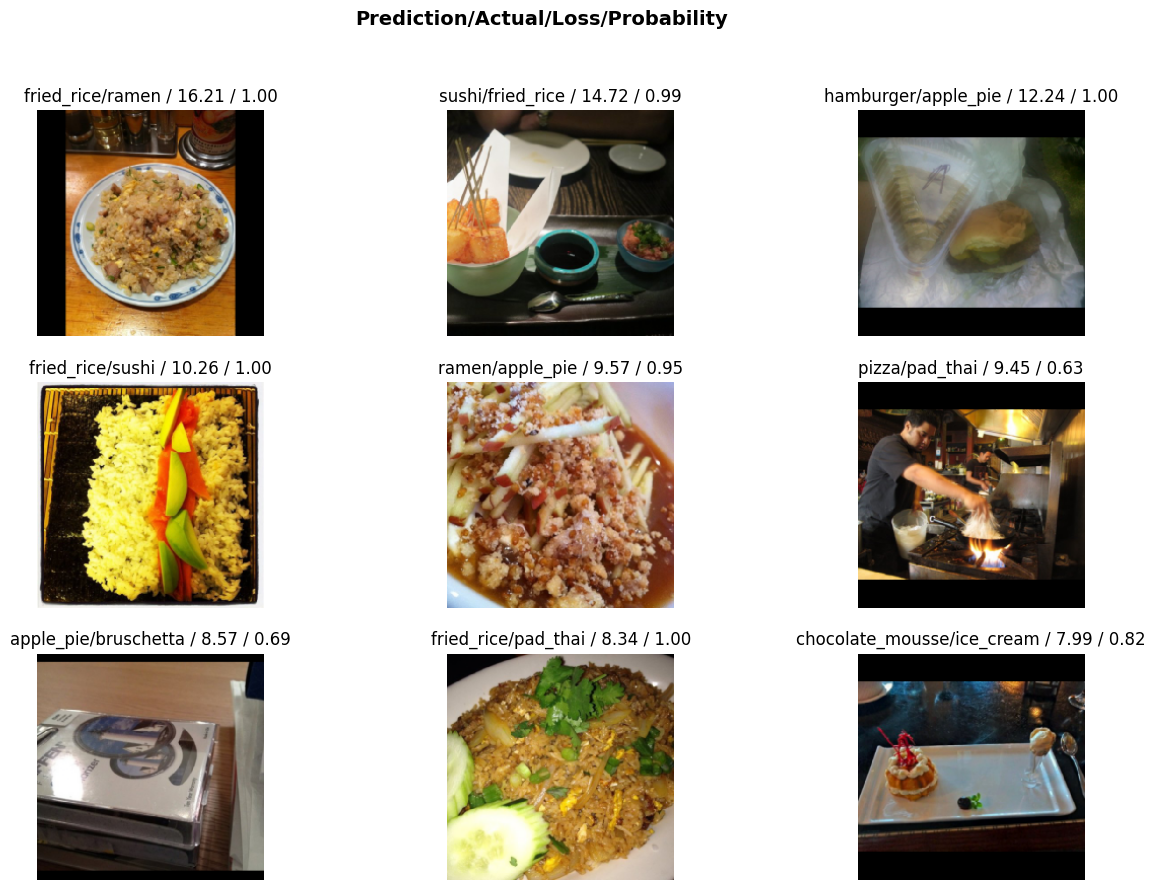

In [20]:
learning_interpreter.plot_top_losses(9, figsize=(15,10))

## Gradio App

In [21]:
learn = load_learner('/home/bennyface/foody_v4_convnext_small_in22k.pkl')

In [22]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [23]:
gr.Interface(fn=predict, inputs=gr.Image(shape=(512, 512)), outputs=gr.Label(num_top_classes=3)).launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://d1e2328e-9a53-4421.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
